Import the library

In [1]:
from carculator import *

Load the default car parameters

In [2]:
cip = CarInputParameters()

Define the calculation mode: static or stochastic(number of iterations)

In [3]:
cip.static()

Fill-in the array that will be used to create the car models

In [4]:
dcts, array = fill_xarray_from_input_parameters(cip)

We can check the powertrains, sizes and yers considered

In [12]:
list(array.powertrain.values)

['BEV',
 'FCEV',
 'HEV-p',
 'ICEV-d',
 'ICEV-g',
 'ICEV-p',
 'PHEV',
 'PHEV-c',
 'PHEV-e']

In [15]:
list(array.year.values)

[2017, 2040]

We can create now the car models, using the default parameters, while specifying a driving cycle

In [35]:
cm = CarModel(array, cycle='WLTC')

Alternatively, we can override specific parameters value, by passing a dicitonary or a filepath to an Excel file.
For we wan to lower the lifetime of the car:

In [44]:
dict_param = {('Driving', 'all', 'all', 'lifetime kilometers', 'none'): {(2017, 'loc'): 150000, (2040, 'loc'): 150000}}
modify_xarray_from_custom_parameters(dict_param, array)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

Let's look at the Tank-to-wheel energy, for a Large diesel

In [46]:
cm.array.sel(powertrain='ICEV-d', size='Large', value=0, parameter='TtW energy')

<xarray.DataArray (year: 2)>
array([2609.00601431, 1733.878351  ])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2017 2040
    value       int32 0

Or we indicate a filepath to the Excel file that contains customized values

In [49]:
fp = r'C:\Users\romai\Documents\Notebooks\template_workbook.xlsx'
modify_xarray_from_custom_parameters(fp, array)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

In [4]:
cm.array.sel(powertrain='ICEV-d', size='Large', value=0, parameter='curb mass')

<xarray.DataArray (year: 2)>
array([1726.0247417 , 1608.78644271])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'curb mass'
  * year        (year) int32 2017 2040
    value       int32 0

In [9]:
cm.array.sel(powertrain='ICEV-d', size='Large', value=0, parameter='TtW energy')

<xarray.DataArray (year: 2)>
array([2609.00601431, 1733.878351  ])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2017 2040
    value       int32 0

We can also override calculated parameters. For example, the driving mass:

In [25]:
cm.array.loc['Large','ICEV-d','driving mass',:] = [[2000],[2200]]

In [26]:
cm.array.loc['Large','ICEV-d','driving mass',:] 

<xarray.DataArray (year: 2, value: 1)>
array([[2000.],
       [2200.]])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'driving mass'
  * year        (year) int32 2017 2040
  * value       (value) int32 0

In [27]:
cm.set_ttw_efficiency()
cm.calculate_ttw_energy()

In [28]:
cm.array.sel(powertrain='ICEV-d', size='Large', value=0, parameter='TtW energy')

<xarray.DataArray (year: 2)>
array([2713.74875752, 2011.73573948])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2017 2040
    value       int32 0

We can also change the driving cycle, among those offered:
* WLTC
* WLTC 3.1
* WLTC 3.2
* WLTC 3.3
* WLTC 3.4
* CADC Urban
* CADC Road
* CADC Motorway
* CADC Motorway 130
* CADC
* NEDC

In [51]:
cm = CarModel(array, cycle='CADC')
cm.set_all()
cm.array.sel(powertrain='ICEV-d', size='Large', value=0, parameter='TtW energy')

<xarray.DataArray (year: 2)>
array([3466.83381274, 2357.58197706])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2017 2040
    value       int32 0

Or even add our own driving cycle

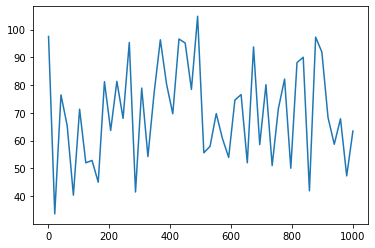

In [8]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(1, 1000)
def f(x):
    return np.sin(x) + np.random.normal(scale=20, size=len(x)) + 70
plt.plot(x, f(x))

In [9]:
cycle = f(x)
cm = CarModel(array, cycle=cycle)
cm.set_all()
cm.array.sel(powertrain='ICEV-d', size='Large', value=0, parameter='TtW energy')

<xarray.DataArray (year: 2)>
array([13262.52115506,  9774.55145091])
Coordinates:
    size        <U12 'Large'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2017 2040
    value       int32 0

We can plot any attributes of the car models

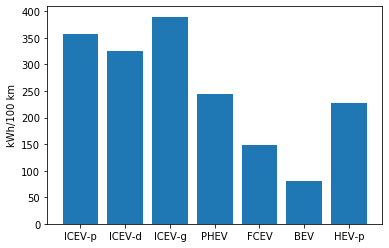

In [10]:
TtW_energy = cm.array.sel(size='SUV', year=2017, parameter='TtW energy', value=0) * 1/3600 * 100

plt.bar(TtW_energy.powertrain, TtW_energy)
plt.ylabel('kWh/100 km')
plt.show()

The same can be done considering uncertainties in input parameters

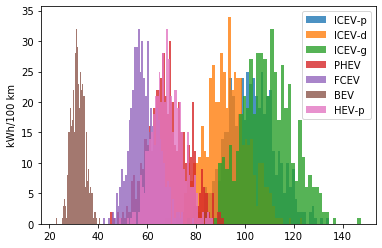

In [23]:
cip = CarInputParameters()
cip.stochastic(500)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='CADC')
cm.set_all()
TtW_energy = cm.array.sel(size='SUV', year=2017, parameter='TtW energy') * 1/3600 * 100

l_powertrains = TtW_energy.powertrain
[plt.hist(e, bins=50, alpha=.8, label=e.powertrain.values) for e in TtW_energy]
plt.ylabel('kWh/100 km')
plt.legend()

In [21]:
cm.array.sel(size='SUV', year=2017, parameter='TtW energy', value=0) * 1/3600 * 100

<xarray.DataArray (powertrain: 7)>
array([106.64760277,  93.56605243, 117.09100362,  81.59435557,
        62.27939141,  34.49074404,  73.60705128])
Coordinates:
    size        <U12 'SUV'
  * powertrain  (powertrain) <U6 'ICEV-p' 'ICEV-d' 'ICEV-g' ... 'BEV' 'HEV-p'
    parameter   <U48 'TtW energy'
    year        int32 2017
    value       int32 0

We can look at noise emissions

Text(0, 0.5, 'joules per km')

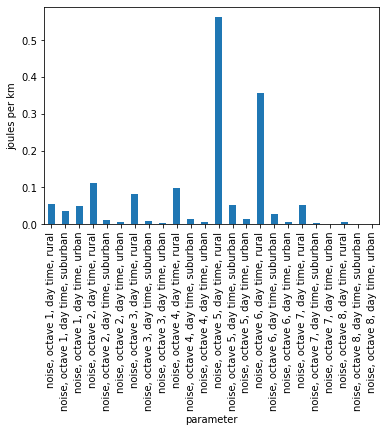

In [29]:
list_param = list(cm.array.parameter.values)
noise_emissions = [x for x in list_param if 'noise' in x]
data = cm.array.sel(parameter=noise_emissions, year=2017, size='Van', powertrain='ICEV-p', value=0)\
    .to_dataframe(name='noise emissions')['noise emissions']
data[data>0].plot(kind='bar')
plt.ylabel('joules per km')

Calculation of the inventories

In [33]:
ic = InventoryCalculation(array)

We can have a look at the underlying technology matrix

In [36]:
ic.A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

The labels of its rows and columns

In [37]:
ic.inputs

{('Sulfur', ('water', 'surface water')): 0,
 ('Sugar beet cultivation {RER} | sugar beet production Europe | Alloc Rec, U',
  'RER'): 1,
 ('market for integrated circuit, logic type', 'GLO'): 2,
 ('market for urea, as N', 'GLO'): 3,
 ('Carbon dioxide, non-fossil', ('air',)): 4,
 ('Toluene', ('air',)): 5,
 ('biodiesel production from algae', 'RER'): 6,
 ('heat production, natural gas, at boiler condensing modulating >100kW',
  'Europe without Switzerland'): 7,
 ('electricity production, hard coal', 'DE'): 8,
 ('wire drawing, copper', 'RoW'): 9,
 ('Battery cell', 'GLO'): 10,
 ('market for cable, ribbon cable, 20-pin, with plugs', 'GLO'): 11,
 ('market for concrete, high exacting requirements', 'CH'): 12,
 ('market for zeolite, powder', 'GLO'): 13,
 ('Propane', ('air',)): 14,
 ('noise, octave 1, day time, urban', ('octave 1', 'day time', 'urban')): 15,
 ('treatment of waste mineral wool, inert material landfill', 'CH'): 16,
 ('Electricity, high voltage, nuclear- PWR, at grid', 'RER'): 17,

For now, only the Recipe Midpoint methods are present. LCIA scores can be obtained this way:

In [9]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.static()
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)
results = ic.calculate_impacts()

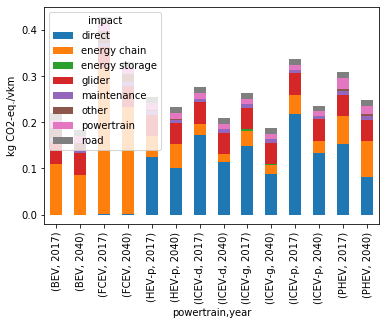

In [10]:
results.sel(impact_category='climate change', size='Large', value=0).to_dataframe('impact').unstack(level=2)['impact'].plot(kind='bar',
                stacked=True)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

We can specify a scope, to narrow the analysis down to specific vehicles

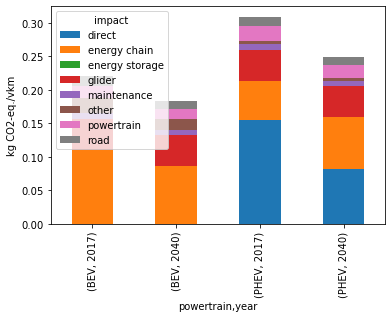

In [11]:
scope = {
    'powertrain':['BEV', 'PHEV'],
}
results = ic.calculate_impacts(scope = scope)
results.sel(impact_category='climate change', size='Large', value=0).to_dataframe('impact').unstack(level=2)['impact'].plot(kind='bar',
                stacked=True)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

In [86]:
cip = CarInputParameters()
cip.stochastic(50)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)

scope = {
    'powertrain':['BEV', 'PHEV'],
}

results = ic.calculate_impacts(scope=scope)

Text(0, 0.5, 'kg CO2-eq./vkm')

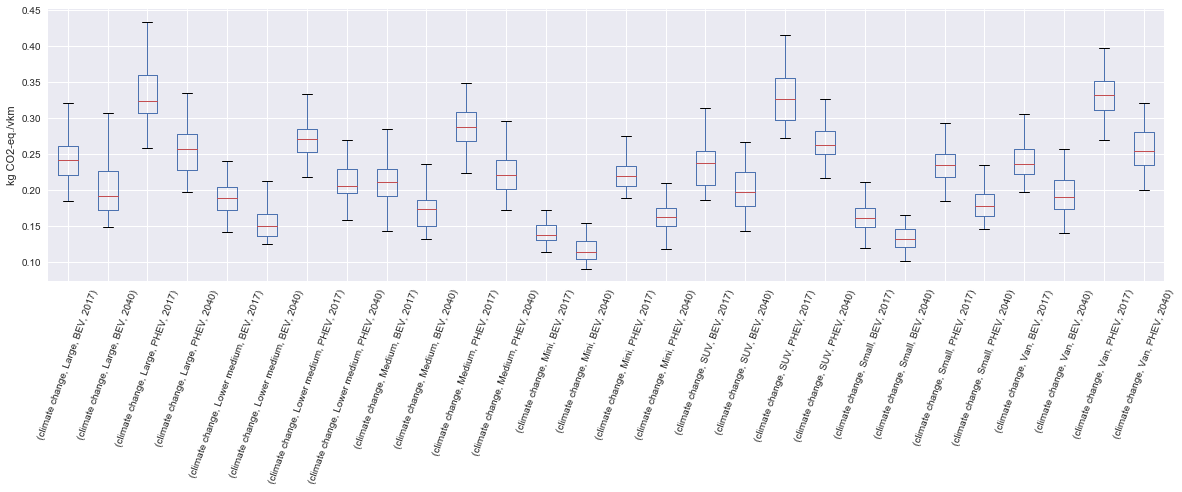

In [91]:
data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')

We can specify background assumptions

For example, we wish to charge BEV batteries with German electricity

Text(0, 0.5, 'kg CO2-eq./vkm')

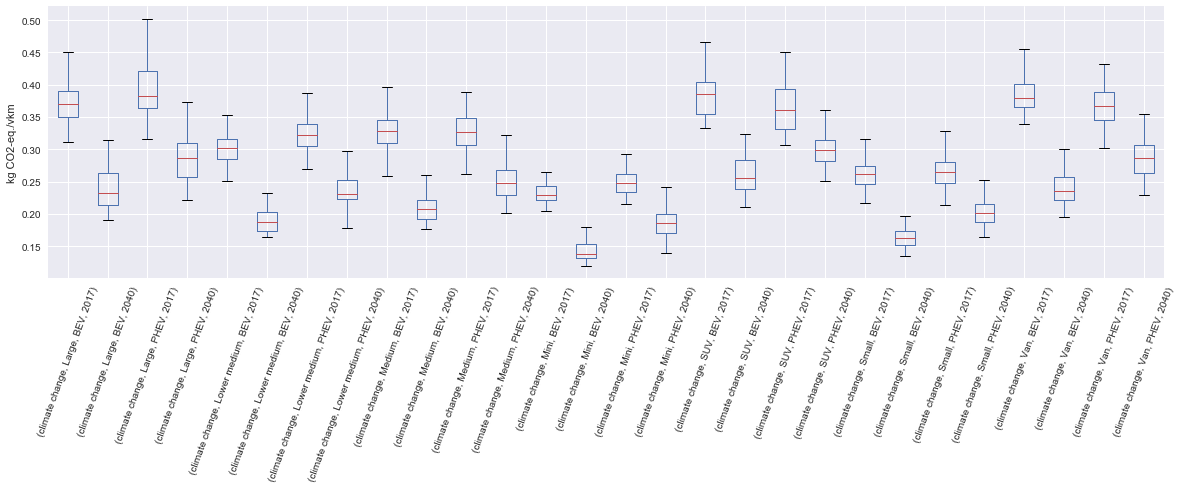

In [92]:
scope = {
    'powertrain':['BEV', 'PHEV'],
}

background_configuration = {
   'background_country' : 'DE' 
}

results = ic.calculate_impacts(scope = scope, background_configuration = background_configuration)

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')

Or with a specific electricity mix in mind...

Text(0, 0.5, 'kg CO2-eq./vkm')

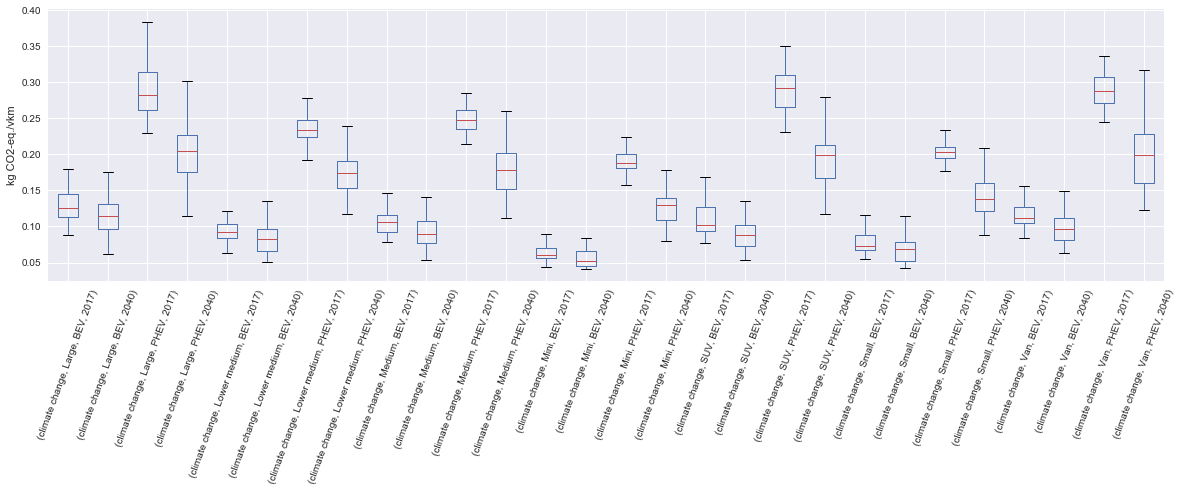

In [6]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.stochastic(50)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)

scope = {
    'powertrain':['BEV', 'PHEV'],
}

"""
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste
"""
background_configuration = {
    'background_country' : 'DE', # will use the network electricity losses of Germany
    'custom electricity mix' : [[.5,.5,0,0,0,0,0,0,0,0],
                                [.5,.5,0,0,0,0,0,0,0,0]] # in this case, 50% hydro, 50% nuclear
}

results = ic.calculate_impacts(scope = scope, background_configuration = background_configuration)

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')

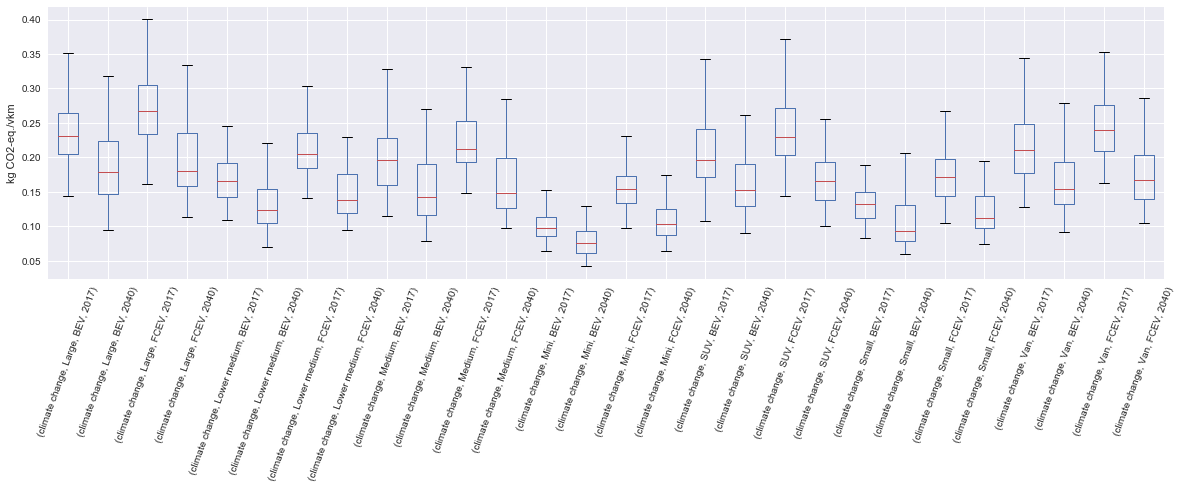

In [27]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.stochastic(100)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)

scope = {
    'powertrain':['BEV', 'FCEV'],
}

"""
Electricity mixes
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste

Hydrogen technologies
hydrolysis
hydrolysis - solar
hydrolysis - hydro
hydrolysis - nuclear
SMR
"""
background_configuration = {
    'background_country' : 'DE', # will use the network electricity losses of Germany
    'custom electricity mix' : [[0.5,0.5,0,0,0,0,0,0,0,0],
                                [0.5,0.5,0,0,0,0,0,0,0,0]], # in this case, 50% hydro, 50% nuclear
    'hydrogen technology' : 'hydrolysis - hydro'
}

results = ic.calculate_impacts(scope = scope, background_configuration = background_configuration)

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

In [21]:
[ic.inputs[i] for i in ic.inputs if 'solar PV' in i[0]]

[38]

In [23]:
[ic.inputs[i] for i in ic.inputs if 'FCEV' in i[0]]

[612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625]

In [24]:
ic.A[38,612]

-0.012595534917734245

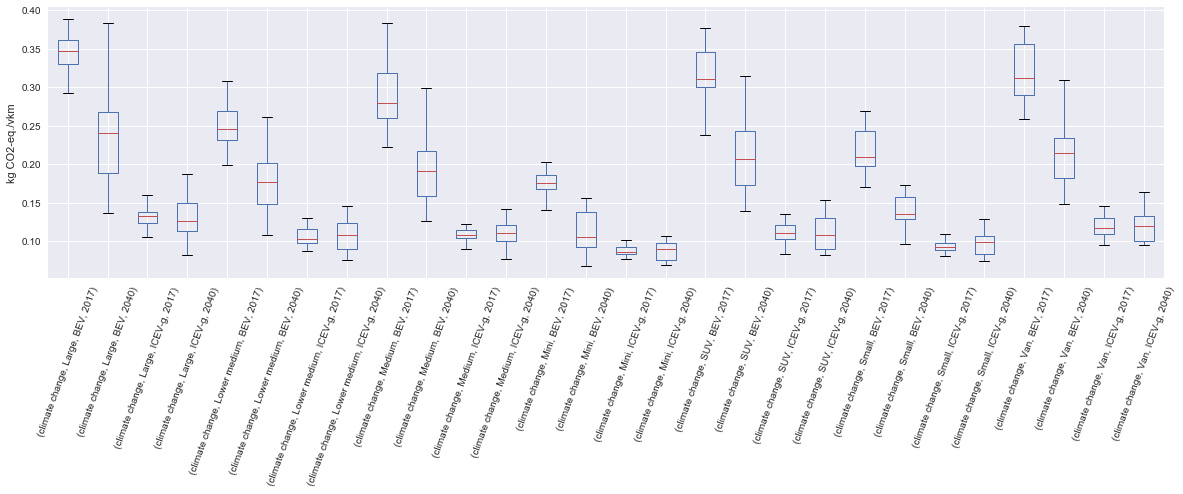

In [2]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.stochastic(20)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)

scope = {
    'powertrain':['BEV', 'ICEV-g'],
}

"""
Electricity mixes
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste

Hydrogen technologies
hydrolysis
hydrolysis - solar
hydrolysis - hydro
hydrolysis - nuclear
SMR

Natural gas technologies
cng
biogas

"""
background_configuration = {
    'background_country' : 'DE', # will use the network electricity losses of Germany
    'cng technology' : 'biogas'
}

results = ic.calculate_impacts(scope = scope, background_configuration = background_configuration)

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

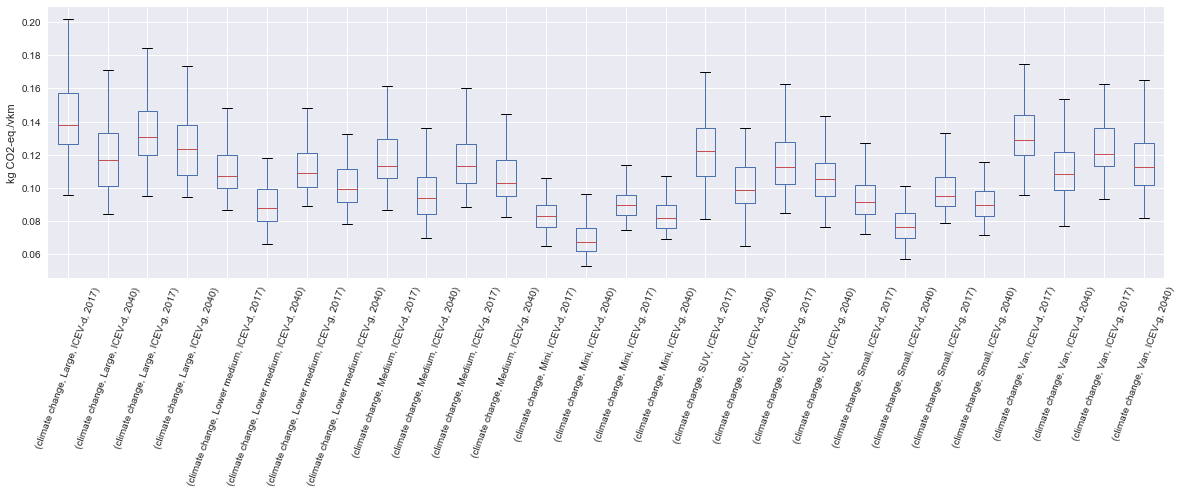

In [2]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.stochastic(100)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)

scope = {
    'powertrain':['ICEV-d', 'ICEV-g'],
}

"""
Electricity mixes
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste

Hydrogen technologies
hydrolysis
hydrolysis - solar
hydrolysis - hydro
hydrolysis - nuclear
SMR

Natural gas technologies
cng
biogas

Diesel technologies
diesel
biodiesel - algae
biodiesel - cooking oil

"""
background_configuration = {
    'background_country' : 'DE', # will use the network electricity losses of Germany
    'cng technology' : 'biogas',
    'diesel technology': 'biodiesel - cooking oil'
}

results = ic.calculate_impacts(scope = scope, background_configuration = background_configuration)

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

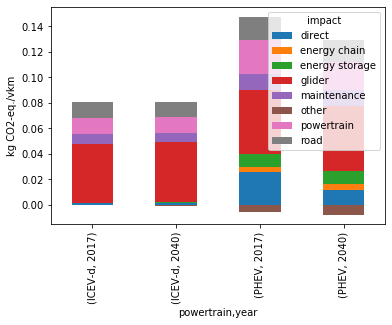

In [3]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.static()
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)

scope = {
    'powertrain':['ICEV-d', 'PHEV'],
}

"""
Electricity mixes
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste

Hydrogen technologies
hydrolysis
hydrolysis - solar
hydrolysis - hydro
hydrolysis - nuclear
SMR

Natural gas technologies
cng
biogas

Diesel technologies
diesel
biodiesel - algae
biodiesel - cooking oil

Petrol technologies
petrol
bioethanol - wheat straw
bioethanol - maize starch
bioethanol - sugarbeet
bioethanol - forest residues

"""
background_configuration = {
    'background_country' : 'DE', # will use the mix and network electricity losses of Germany
    'petrol technology' : 'bioethanol - maize starch',
    'diesel technology': 'biodiesel - cooking oil',
    'custom electricity mix' : [[0.5,0.5,0,0,0,0,0,0,0,0],
                                [0.5,0.5,0,0,0,0,0,0,0,0]], # in this case, 50% hydro, 50% nuclear
}

results = ic.calculate_impacts(scope = scope, background_configuration = background_configuration)

results.sel(impact_category='climate change', size='Large', value=0).to_dataframe('impact').unstack(level=2)['impact'].plot(kind='bar',
                stacked=True)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

In [12]:
[ic.inputs[i] for i in ic.inputs if 'Carbon dioxide, fossil' in i[0] and i[1] == ('air',) ]

[70]

In [7]:
[ic.inputs[i] for i in ic.inputs if 'wheat straw' in i[0]]

[17]

In [20]:
ic.B[6,17]*3.2

0.044563737815307876

In [12]:
ic.B[6,19]

0.6246977326460438

In [11]:
[ic.inputs[i] for i in ic.inputs if 'low-sulfur' in i[0]]

[19]

In [10]:
ic.B[6,161]

0.10200158973183246

In [17]:
index = ic.get_index_from_array(["ICEV-p"])
ic.temp_array[ic.array_inputs["fuel mass"], index]/ ic.temp_array[ic.array_inputs["range"], index]

array([0.0679511 , 0.04181724, 0.05702822, 0.03567876, 0.06196559,
       0.03834115, 0.04715161, 0.03020517, 0.07272846, 0.04620031,
       0.05058089, 0.03204946, 0.06992433, 0.04425941])